# Problem Statement

A pizza delivery company is building a CLTV model to inform ROIs to its paid acquisition and retention efforts. The ultimate goal is to be able to provide insight and direction to help inform and optimize paid marketing efforts across various channels.

Using the attached dataset, please determine:

1. Cohort values. Feel free to define cohorts however you’d like.
2. Customer Lifetime Value. How much value would each customer bring to the company over their lifetime?
3. What are some key insights from the analysis?
4. What are some caveats to this analysis using only the provided data? What type of data would be ideal to get more refined value modeling?

Feel free to make assumptions as needed and note that the company makes $1.95 per order.

# Index 
1. Data Loading
2. Explorative Analysis
3. Data Manipulation
4. Question 1: Clustering & Cohort Analysis 
5. Question 2: CLTV Model (MBD/BG & BD/BG) 
6. Question 3 & 4: Insights & Analysis

# Data Loading 

In [2]:
# loading packages
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px
import os

# loading data
os.getcwd()
os.chdir("/Users/su.min.park@ibm.com/Documents/LiveChatBot")
data = pd.read_csv('CLTVData.csv')


# Exploratory Analysis
Let's take a quick look at the data set before segmenting the data into several cohorts. 

In [2]:
# data type & summary stats of each column 
data.info()
data.describe()
data.shape
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16131 entries, 0 to 16130
Data columns (total 8 columns):
order_id            16131 non-null int64
source              16131 non-null object
purchase_date       16131 non-null object
shipping_type       13579 non-null object
payment_method      13579 non-null object
promo_amount        860 non-null float64
restaurant_total    16131 non-null float64
user_id             16131 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 1008.3+ KB


order_id  source     purchase_date shipping_type payment_method  \
0  15584975  iosapp    3/3/2019 13:08      Delivery         credit   
1  13348282  iosapp  11/24/2018 20:44        Pickup         credit   
2  12582969  google  10/19/2018 13:31        Pickup         credit   
3  12931902  iosapp   11/4/2018 14:08        Pickup         credit   
4  14884422     web    2/2/2019 21:26      Delivery         credit   

   promo_amount  restaurant_total  user_id  
0           NaN             13.63    12621  
1           NaN             15.40    21165  
2           NaN             10.50    18651  
3           NaN             77.52    13733  
4           NaN             43.57    13052

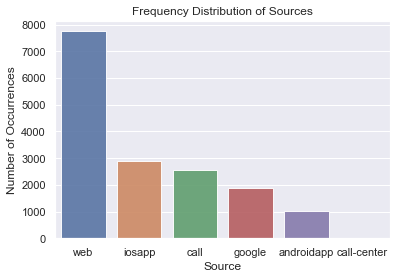

In [3]:
# let's draw bar graphs for each categorical variable 
# Source 
source_count = data['source'].value_counts()
sns.set(style="darkgrid")
sns.barplot(source_count.index, source_count.values, alpha=0.9)
plt.title('Frequency Distribution of Sources')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Source', fontsize=12)
plt.show()

Web is the most common source of order, then iosapp, call, google, and android app. Call-center is rarely used. 

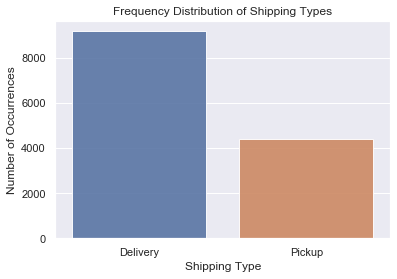

In [4]:
# Shipping type
shipping_type_count = data['shipping_type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(shipping_type_count.index, shipping_type_count.values, alpha=0.9)
plt.title('Frequency Distribution of Shipping Types')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Shipping Type', fontsize=12)
plt.show()

Delivery is more than twice as frequently used of a shipping type. Initial data set only lists delivery and pick up as the available shipping type. You'll see in the later plots that I labeled the "blank" category as "phone," after confirming with Melanie that phone orders originate from a different system and therefore unable to be tracked for Shipping or Payment Method data.

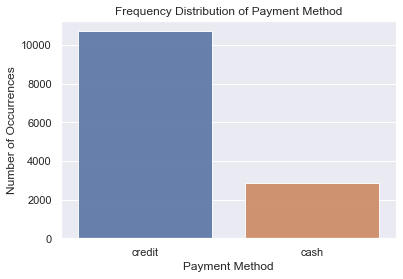

In [5]:
# Payment Method  
payment_method_count = data['payment_method'].value_counts()
sns.set(style="darkgrid")
sns.barplot(payment_method_count.index, payment_method_count.values, alpha=0.9)
plt.title('Frequency Distribution of Payment Method')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Payment Method', fontsize=12)
plt.show()


Credit is is more than 3 times commonly used of a payment method than cash. Makes sense since it's easier to pay with credit card when you order delivery, and delivery is more common than pickup for the company.

In [6]:
# Promo Amount 
promo_amount_count = data['promo_amount'].value_counts()
sns.set(style="darkgrid")
sns.barplot(promo_amount_count.index, promo_amount_count.values, alpha=0.9)
plt.title('Frequency Distribution of Promo Amounts')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Promo Amount', fontsize=12)
plt.show()


30% off promotion is three times more common than 50% off, which is the 2nd most frequent promo amounts. I see a minimal amount of 70% orders too. I wonder if these are the new users' first time discounted orders or the repeat customers who were rewarded with the limited time deals.  

# Data Manipulation
Let's change the variable types, identify the unknowns/nulls, and remove the outliers as needed. For food orders, weekday and hour of the day information will be crucial in designing a personalized, hyper-targeted advertising & promotion campaign. Note that I ignored the restaurant open/close times for now in constructing time brackets.

In [7]:
# extract month, year, day, and time bracket info from the purchase date column 
import datetime 
data['purchase_year'] = pd.DatetimeIndex(data['purchase_date']).year
data['purchase_month'] = pd.DatetimeIndex(data['purchase_date']).month
data['purchase_day'] = pd.DatetimeIndex(data['purchase_date']).weekday_name
data['purchase_hour'] = pd.DatetimeIndex(data['purchase_date']).hour
data['purchase_year_month'] = pd.DatetimeIndex(data['purchase_date']).year.map(str) + "-" + pd.DatetimeIndex(data['purchase_date']).month.map(str)

#data.info()
#data.describe()
data.dtypes

# let's assign hour brackets for more granular analysis! 
def time_bracket(x): 
    if (x >=5 and x < 11): return 'morning'
    if (x >=11 and x < 17): return 'lunch'
    if (x >=17 and x < 23): return 'dinner'
    else: return 'latenight'
    
data['time_bracket'] = data['purchase_hour'].apply(time_bracket)
data.head()


order_id  source     purchase_date shipping_type payment_method  \
0  15584975  iosapp    3/3/2019 13:08      Delivery         credit   
1  13348282  iosapp  11/24/2018 20:44        Pickup         credit   
2  12582969  google  10/19/2018 13:31        Pickup         credit   
3  12931902  iosapp   11/4/2018 14:08        Pickup         credit   
4  14884422     web    2/2/2019 21:26      Delivery         credit   

   promo_amount  restaurant_total  user_id  purchase_year  purchase_month  \
0           NaN             13.63    12621           2019               3   
1           NaN             15.40    21165           2018              11   
2           NaN             10.50    18651           2018              10   
3           NaN             77.52    13733           2018              11   
4           NaN             43.57    13052           2019               2   

  purchase_day  purchase_hour purchase_year_month time_bracket  
0       Sunday             13              2019-3        lunch  
1     Saturday             20             2018-11       dinner  
2       Friday             13             2018-10        lunch  
3       Sunday             14             2018-11        lunch  
4     Saturday             21              2019-2       dinner

In [8]:
# create box plots to see distribution and remove outliers
# restaurant total 
ax = px.box(data, y="restaurant_total")
ax.show()

Plotly plots didn't display in the PDF version, but can be seen in the code file. Drawing a vertical boxplot highlights the few outliers in the restaurant_total column. There are 7 outliers beyond the upper fence (55.17), the max being 1116.57. This may be a catering order for a large corporate event or conference. Smaller ones around 325 and 200 may be for smaller or personal events like football or Oscar viewing parties. Median order value is $29 (you can view the numbers when you hover over the plot).

In [9]:
# weekday x restaurant_total

bx = px.box(data, x="purchase_day", y="restaurant_total")
bx.update_layout(xaxis = dict(tickmode = 'linear'))
bx.show()

While the median and quartile values don't vary too much across days, Thursday and Friday have a much larger range and greater number of outliers.

In [10]:
# source x restaurant total 
gx = px.box(data, x="source", y="restaurant_total")
gx.update_layout(xaxis = dict(tickmode = 'linear'))
gx.show()

With the exception of Call, all other sources have a similar median & range. Web has a disproportionately greater number of outliers. 

In [11]:
cx = px.box(data, x="shipping_type", y="restaurant_total")
cx.update_layout(xaxis = dict(tickmode = 'linear'))
cx.show()

In [12]:
dx = px.box(data, x="payment_method", y="restaurant_total")
dx.update_layout(xaxis = dict(tickmode = 'linear'))
dx.show()

In [13]:
ex = px.box(data, x="purchase_month", y="restaurant_total")
ex.update_layout(xaxis = dict(tickmode = 'linear'))
ex.show()

More expensive orders exist for Web, Delivery, Credit Card, and Thursday/Friday orders and are more common in July and the winter months (November through January). One thing to note is that the discrepancy between different categories is larger for the payment method, with credit card orders being more expensive than cash orders in terms of median and range ($65 > $52). 

In [14]:
# further data preprocessing
# identify columns with blanks 

null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()


# replace blanks in shipping_type and payment_method with "phone" and those in promo with 0. 
data['shipping_type'].fillna("phone", inplace=True)
data['payment_method'].fillna("phone", inplace=True)
data['promo_amount'].fillna(0, inplace=True)

# check again to see if imputation worked 
data[null_columns].isnull().sum()

# number of orders above the upper fence (55.17) in restaurant total column
sum(i > 56 for i in data['restaurant_total'])
 
# save the preprocessed dataset to a new file
data.to_csv("CLTVData_Preprocessed.csv", index=False, header=True)

Exactly 2552 rows have shipping_type and payment_method blank. Dropping these NAs completely may be risky since it constitutes 15% of the data set and confirmed with Melanie that these should belong to the "phone" category. 15271 rows have promo_amount blank, and confirmed that these rows are safe to interpret as 0 promo. Number of orders beyond the upper fence value is 1004, which is 6% of the entire data set. This isn't a miniscule portion, so I decided to keep these expensive orders in the data. 

# Question 1: Clustering & Cohort Analysis 

Time for clustering! I want to use the two most common clustering methods: 1) k-means and 2) hierarchical. Let's use h2o for faster iterations of the intial model, but for more granular evaluation metrics and hierarchical clustering, I'll need to use scikit-learn, since H2o isn't yet as comprehensive of a tool.

The reason I am doing both K-means and agglomerative hierarchical clustering is because they are fundamentally different approaches, K-means being "bottom-up" where all observations starting in one big cluster then split, and agglomerative hierarchical being "top-down" where each observation starts in its own cluster, then pairs of clusters are merged as one moves up the hierarchy.

I used H2o for k-means and sckit-learn for hierarchical, and set the parameters accordingly so that both primarily aim to separate samples in n groups of equal variance (or "minimize the total within-cluster variance"). Also note that I conducted "stratified sampling" based on payment method, so that both train and test sets have an equal proportion of credit and cash orders. Since the boxplots in Section 5 showed that credit card orders have a significantly larger median and an upper fence than cash in order value, this will help us have more faith in applying our model to the test set. 

## K-Means Clustering

In [15]:
import h2o
h2o.init()

# read in file 
h2o_data = h2o.upload_file("CLTVData_Preprocessed.csv")
# check that NAs are gone in this file. Missing is 0 for all columns! woohoo.

# let's remove the ids, purchase date, year, and month. Let's keep weekday, year-month, and time brackets as they can be defining cluster traits. 
h2o_data.drop(index=['order_id', 'purchase_date', 'user_id', 'purchase_year', 'purchase_month'], axis=1)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/su.min.park@ibm.com/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/vc/82_m0n_j2wjbms19xjw2h2dc0000gn/T/tmpzu5h9zu8
  JVM stdout: /var/folders/vc/82_m0n_j2wjbms19xjw2h2dc0000gn/T/tmpzu5h9zu8/h2o_su_min_park_ibm_com_started_from_python.out
  JVM stderr: /var/folders/vc/82_m0n_j2wjbms19xjw2h2dc0000gn/T/tmpzu5h9zu8/h2o_su_min_park_ibm_com_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.8
H2O cluster version age:    14 days, 15 hours and 37 minutes
H2O cluster name:           H2O_from_python_su_min_park_ibm_com_a8ffk4
H2O cluster total nodes:    1
H2O cluster free memory:    1.778 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.4 final
--------------------------  ------------------------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


source shipping_type payment_method promo_amount restaurant_total purchase_day purchase_hour purchase_year_month time_bracket 
 
 
 iosapp Delivery credit 0 13.63 Sunday 13 2019-03-01 00:00:00 lunch 
 iosapp Pickup credit 0 15.4 Saturday 20 2018-11-01 00:00:00 dinner 
 google Pickup credit 0 10.5 Friday 13 2018-10-01 00:00:00 lunch 
 iosapp Pickup credit 0 77.52 Sunday 14 2018-11-01 00:00:00 lunch 
 web Delivery credit 0 43.57 Saturday 21 2019-02-01 00:00:00 dinner 
 androidapp Delivery credit 0 19.76 Tuesday 15 2019-03-01 00:00:00 lunch 
 web Pickup credit 0 48.79 Sunday 17 2018-12-01 00:00:00 dinner 
 google Pickup credit 0 15.63 Thursday 14 2018-11-01 00:00:00 lunch 
 call phone phone 0 29 Thursday 17 2018-09-01 00:00:00 dinner 
 iosapp Delivery credit 0 20.03 Tuesday 12 2018-12-01 00:00:00 lunch

In [16]:
# Stratified split into 70% training and 30% test dataset based on "payment method," since credit card orders had a larger median and an upper fence than cash in the boxplots in Section 5 and the discrepancy was larger than other factors. 
# We want a proportionate representation of credit orders in training & test sets
strat_split = h2o_data['payment_method'].stratified_split(test_frac=0.3, seed=42)
train = h2o_data[strat_split == 'train']
test = h2o_data[strat_split == 'test']

# Build a k-means clustering model 

from h2o.estimators.kmeans import H2OKMeansEstimator
results = [H2OKMeansEstimator(k=clusters, init="Random", seed=2, standardize=True, categorical_encoding="auto") for clusters in range(2,13)]
for estimator in results:
    estimator.train(x=train.col_names[0:-1], training_frame = train, validation_frame = test)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [17]:
# let's use the "elbow method" to determine the optimal number of clusters! 
import math as math

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)
diagnostics.plot(kind='line');

Elbow method is used to find the optimal number of clusters in a dataset, but since it is often ambiguous and not very reliable, other evaluation approaches such as Silhouette method, gap statistic, and grid search is used to further validate the "k" of the K-means clustering. 

If one plots the percentage of variance (or deviation from the general trend) explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of the variance), but at some point the marginal gain will drop, giving an angle (or an "elbow"), in the graph.

For this case, the elbow looks like it's either 3, 5, or 6, but we can't declare definitively. Note that for this graph, I used Total Within Sum of Squares, Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC), which are criterions we should try to minimize to ensure that each cluster is compact. 


While I used H2o for faster iterations of K-means, let's switch back to our good old scikit-learn to use the Silhouette method to evaluate our K-Means model. A silhouette score of a data point is a measure of how "close" it is to other data points within the same cluster and how "distant" (or different) it is from points in other clusters. It ranges from -1 to 1, and the closer it is to 1, the better defined of a clustering.

In [18]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from sklearn import preprocessing

# read in processed data
data = pd.read_csv("CLTVData_Preprocessed.csv")
data = data[['source', 'shipping_type', 'payment_method', 'promo_amount', 'restaurant_total', 'purchase_day', 'purchase_year_month', 'time_bracket']]

# one hot encode categorical variables 
le = preprocessing.LabelEncoder()
data_2 = data.apply(le.fit_transform)
data_2.head()

# stratified split data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_2, stratify=data_2['payment_method'], test_size=0.3)

In [19]:
# getting silhouette scores 
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(data_2)
    centers = clusterer.cluster_centers_

    score = silhouette_score(data_2, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
# drawing silhouette plots 
#model_2 = KMeans(2, random_state=42)
#visualizer = SilhouetteVisualizer(model_2, colors='yellowbrick')
#visualizer.fit(X_train)

model_3 = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model_3, colors='yellowbrick')
visualizer.fit(X_train)

#model_4 = KMeans(4, random_state=42)
#visualizer = SilhouetteVisualizer(model_4, colors='yellowbrick')
#visualizer.fit(X_train)

#model_7 = KMeans(7, random_state=42)
#visualizer = SilhouetteVisualizer(model_7, colors='yellowbrick')
#visualizer.fit(X_train)

#model_8 = KMeans(8, random_state=42)
#visualizer = SilhouetteVisualizer(model_8, colors='yellowbrick')
#visualizer.fit(X_train)

#model_9 = KMeans(9, random_state=42)
#visualizer = SilhouetteVisualizer(model_9, colors='yellowbrick')
#visualizer.fit(X_train)

For n_clusters = 2, silhouette score is 0.6013066635987008)
For n_clusters = 3, silhouette score is 0.6033746796122654)
For n_clusters = 4, silhouette score is 0.595111987364445)
For n_clusters = 5, silhouette score is 0.595641341824891)
For n_clusters = 6, silhouette score is 0.5985484794987882)
For n_clusters = 7, silhouette score is 0.5930544608584645)
For n_clusters = 8, silhouette score is 0.5942917281081941)
For n_clusters = 9, silhouette score is 0.5914783237444274)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a184f7650>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [20]:
model_5 = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model_5, colors='yellowbrick')
visualizer.fit(X_train)

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a162ed0>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [21]:
model_6 = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model_6, colors='yellowbrick')
visualizer.fit(X_train)

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fb12290>,
                     colors='yellowbrick', is_fitted='auto', model=None)

Silhouette scores indicate that 3 or 6 clusters are a better pick with higher silhoutte scores (0.603 and 0.5985), but the results are rather ambivlaent between the two. Silhouette plots show that 5 and 6 cluster models have wider fluctuations in the size of the clusters, despite having a higher score above 0.8 for one of the clusters. In general, segmenting the dataset to more than 5 clusters results in loss of stability, which means that clusterings and the insights obtained from will be more difficult to be generalized to other samples from the order database.

Therefore, we'll go with 3 clusters for this analysis, but it is good to conduct grid search and gap statistic evaluation to investigate further. 


## Hierarchical Clustering
We completed k-means clustering to get 3 clusters. Now time for hierarchical, to see if we also get 3 segments from a bottom-up approach. 

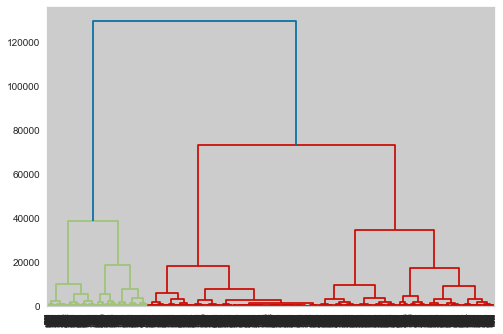

In [22]:
# hierarchical clustering! 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
# create clusters
hc = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
Y_hc = hc.fit_predict(X_train)


Here we have a dendogram, a kind of a connectivity plot that shows how our data is mapped. Numbers on the y-axis represent how close or different the data points are to one another. From this plot, we can see that the daa set can be divided into 3 large clusters or 6 smaller clusters, with two grouped into each of the three big clusters. This is consistent with the findings from k-means in 6.1. 

Traditional approaches of crossvalidation isn't feasible for our analysis, a type of unsupervised learning, where there is no predetermined "ground truth" on which groups our customers should fall into. There is a recently published paper that introduces a form of Gabriel crossvalidation for clustering methods, but I'll continue on to cohort analysis, for the sake of this project (https://arxiv.org/pdf/1702.02658.pdf). 

## Cohort Analysis & Data Visualization

Now that we've settled on 3 clusters, let's examine what each cohort of customers look like.  

In [23]:
# create 3 clusters and add the identified cluster category column to our data set

import h2o
m = H2OKMeansEstimator(k=6, init="Random", seed=2, standardize=True, categorical_encoding="auto") 
m.train(x=h2o_data.col_names[0:-1], training_frame = h2o_data)
p = m.predict(h2o_data)
h2o_data=h2o_data.cbind(p["predict"])

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [24]:
# save the 3 clusters dataset to a new file
h2o.download_csv(h2o_data,"/Users/su.min.park@ibm.com/Documents/LiveChatBot/6Clusters.csv") 

'/Users/su.min.park@ibm.com/Documents/LiveChatBot/6Clusters.csv'

In [3]:
# cohort analysis: data visualization
import pandas as pd 

# read in clustered data
data = pd.read_csv("3Clusters.csv")
data.info()
data.head()

# fix the year-month column 
data=data.drop(columns=['purchase_year_month'])
data['purchase_year_month'] = data['purchase_year'].map(str) + "-" + data['purchase_month'].map(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16131 entries, 0 to 16130
Data columns (total 15 columns):
order_id               16131 non-null int64
source                 16131 non-null object
purchase_date          16131 non-null object
shipping_type          16131 non-null object
payment_method         16131 non-null object
promo_amount           16131 non-null int64
restaurant_total       16131 non-null float64
user_id                16131 non-null int64
purchase_year          16131 non-null int64
purchase_month         16131 non-null int64
purchase_day           16131 non-null object
purchase_hour          16131 non-null int64
purchase_year_month    16131 non-null int64
time_bracket           16131 non-null object
predict                16131 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 1.8+ MB


In [4]:
data['purchase_year_month'] = pd.to_datetime(data['purchase_year_month'],yearfirst=True)
data.head()

order_id  source     purchase_date shipping_type payment_method  \
0  15584975  iosapp    3/3/2019 13:08      Delivery         credit   
1  13348282  iosapp  11/24/2018 20:44        Pickup         credit   
2  12582969  google  10/19/2018 13:31        Pickup         credit   
3  12931902  iosapp   11/4/2018 14:08        Pickup         credit   
4  14884422     web    2/2/2019 21:26      Delivery         credit   

   promo_amount  restaurant_total  user_id  purchase_year  purchase_month  \
0             0             13.63    12621           2019               3   
1             0             15.40    21165           2018              11   
2             0             10.50    18651           2018              10   
3             0             77.52    13733           2018              11   
4             0             43.57    13052           2019               2   

  purchase_day  purchase_hour time_bracket  predict purchase_year_month  
0       Sunday             13        lunch        2          2019-03-01  
1     Saturday             20       dinner        0          2018-11-01  
2       Friday             13        lunch        0          2018-10-01  
3       Sunday             14        lunch        0          2018-11-01  
4     Saturday             21       dinner        2          2019-02-01

Perfecto!! Now let's examine how the attributes change over time. While I would love to create time series models, the date range provided is limited from 2018 June to 2019 March. So let's first look at trends over time.

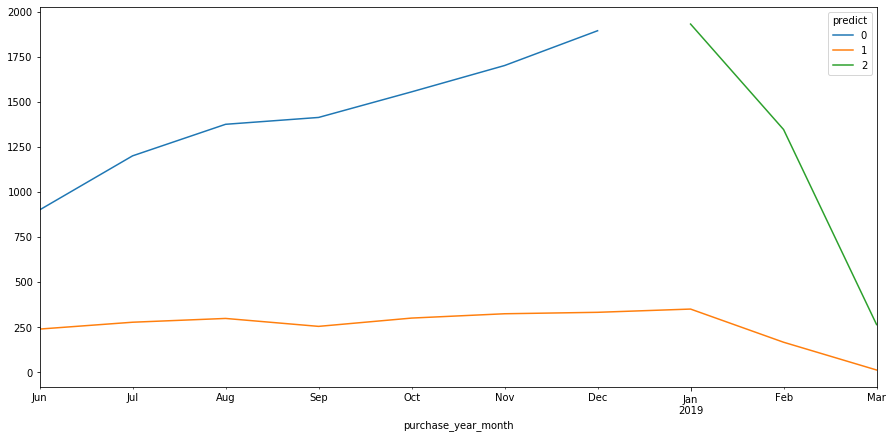

In [5]:
# time series plot
# order count by cluster

data.head()
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','predict']).count()['order_id'].unstack().plot(ax=ax)


The three lines each represent a cluster, marked by numbers 0, 1, and 2. Interesting to note that Cluster 0 saw a steadily increasing trend for the last two quarters of 2018 then completely stops in 2019, while Cluster 2 is only existent for 2019. Both Cluster 1 and 2 took a sharp decline in February 2019. 

February has all 4 weeks of data while March stops at 3/7. We need more historical data from the past few years to determine if this is a seasonal trend, and also more data points from 2019 March onward to decide if the decline is a persisting phenomenon, a temporary dip, or a mere data entry error.


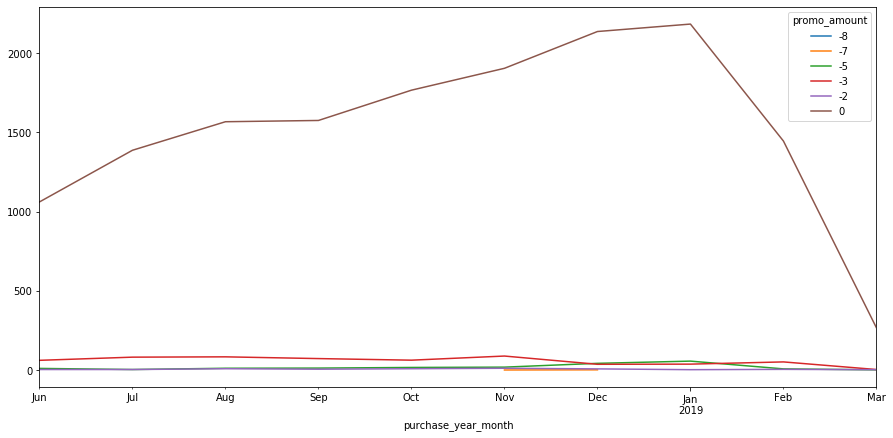

In [6]:
# order count by promo

data['promo_amount'] = data.promo_amount.astype('category')
data.head()
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','promo_amount']).count()['order_id'].unstack().plot(ax=ax)


It's interesting to note that majority of the orders didn't receive any promotion across all months, despite local peaks in November and February.

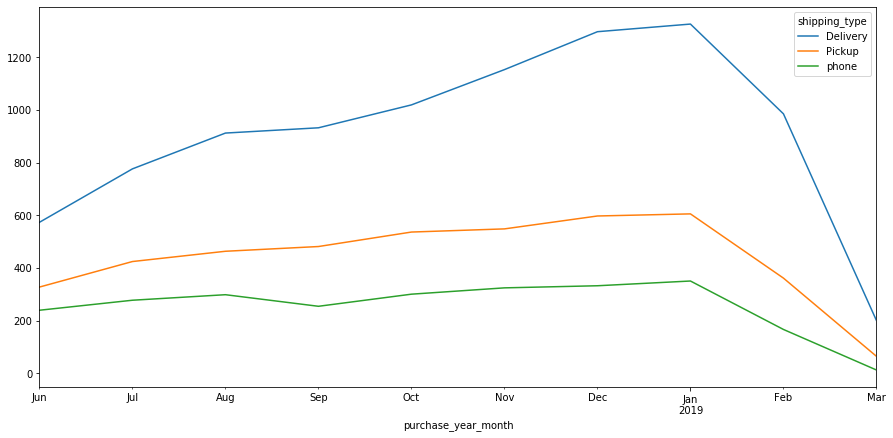

In [7]:
# by shipping type 
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','shipping_type']).count()['order_id'].unstack().plot(ax=ax)

Delivery > Pickup > Phone. Delivery is almost three times as more common as phone. All three shipping types had a rising trend throughout 2018 and declined in 2019. Interesting to note that Cluster 1's trend line from the previous plot is almost identical to "phone"'s. Perhaps Cluster 1 is entirely consisted of phone orders, Cluster 0 of 2018, and Cluster 2 of 2019. This is where I think doing a more granular segmentation of 6 clusters as a follow-up analysis will shed more light on understanding the underlying patterns in the company's customers. However, this level of clustering will only be stable if we had a larger data set across a few years.

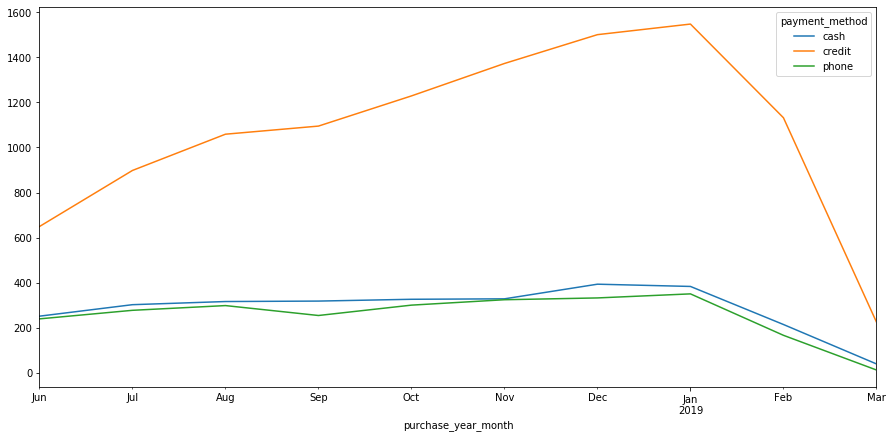

In [8]:
# by payment method
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','payment_method']).count()['order_id'].unstack().plot(ax=ax)

Credit > Cash > Phone. Number of cash orders seems to roughly correlate with pickup orders. We'll need to pivot tables to see the numerical breakdown of payment method x shipping method.

In [9]:
# by time bracket
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','time_bracket']).count()['order_id'].unstack().plot(ax=ax)

Lunch (11am-5pm) > dinner (5-11pm) > morning (5am-11am) > late night (11pm-5am). Interesting to note that more orders are placed during lunch & dinner times. Perhaps this is caused by delivery orders consisting the majority - perhaps late night pizza runs are more likely to be pick up orders or in person (off-company-app) orders. 

In [10]:
# by purchase day
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['purchase_year_month','purchase_day']).count()['order_id'].unstack().plot(ax=ax)

Friday, Saturday and Sunday are Top 3, with more orders placed on weekends than weekdays. Starting last December, Thursday rose over Wednesday.

Now let's dive into more granular cohort analyses. 

In [11]:
# cluster x source x revenue 

sns.set_style('white')
data_group = data.groupby(['predict', 'source']).agg({'restaurant_total': 'sum'}).reset_index()
data_group
data_plot = sns.barplot(data=data_group, x='predict', y='restaurant_total', hue='source', palette = ("Set2"))
plt.show()

# creating a pivot table to see the numerical breakdown
data_2 = data.groupby(['predict', 'source']).agg({'restaurant_total': 'sum', 'source': 'count'})

# add a column: restaurant revenue per user
data_2['revenue per user'] = data_2['restaurant_total']/data_2['source']
data_2

restaurant_total  source  revenue per user
predict source                                                 
0       androidapp           20247.59     676         29.952056
        call-center             86.07       5         17.214000
        google               44515.91    1396         31.888188
        iosapp               53373.85    1917         27.842384
        web                 197403.16    6044         32.661013
1       call                 74008.00    2552         29.000000
2       androidapp           10508.89     340         30.908500
        google               15989.05     502         31.850697
        iosapp               29188.48     991         29.453562
        web                  55363.30    1708         32.414110

Source efficiency: web > gogole > androidapp > iosapp 

Cluster 1, as predicted, is only consisted of call orders and it is powerful source of revenue per user. 
Cluster 0 and 2 have the same source breakdown, with Cluster 0 with more orders coming from google. 
Cluster 2 is seeing very good revenue per user across all sources so far. 

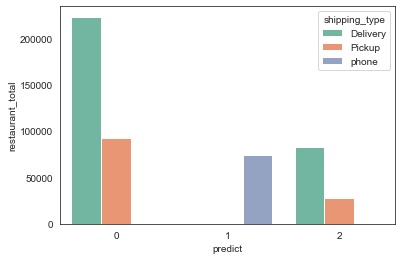

restaurant_total  shipping_type  revenue per user
predict shipping_type                                                   
0       Delivery              223140.56           6662         33.494530
        Pickup                 92486.02           3376         27.395148
1       phone                  74008.00           2552         29.000000
2       Delivery               83009.61           2511         33.058387
        Pickup                 28040.11           1030         27.223408

In [12]:
# cluster x shipping type x revenue

sns.set_style('white')
data_group = data.groupby(['predict', 'shipping_type']).agg({'restaurant_total': 'sum'}).reset_index()
data_group
data_plot = sns.barplot(data=data_group, x='predict', y='restaurant_total', hue='shipping_type', palette = ("Set2"))
plt.show()

# pivot for count, revenue per user per shipping type per cluster

data_3 = data.groupby(['predict', 'shipping_type']).agg({'restaurant_total': 'sum', 'shipping_type': 'count'})
data_3['revenue per user'] = data_3['restaurant_total']/data_3['shipping_type']
data_3



Delivery > pickup for total revenue and revenue per user. I consider this pretty intuitive an average customer is likely to choose delivery for larger orders. Perhaps it's a good idea to start running promotions for delivery orders, such as waiving delivery fee, since the cost involved will likely be covered by larger bills in the long run. 

In [13]:
# cluster x promo amount x revenue

sns.set_style('white')
data_group = data.groupby(['predict', 'promo_amount']).agg({'restaurant_total': 'sum'}).reset_index()
data_group
data_plot = sns.barplot(data=data_group, x='predict', y='restaurant_total', hue='promo_amount', palette = ("Set2"))
plt.show()

# pivot for count, revenue per user per shipping type per cluster

data_3 = data.groupby(['predict', 'promo_amount']).agg({'restaurant_total': 'sum', 'promo_amount': 'count'})
data_3['revenue per user'] = data_3['restaurant_total']/data_3['promo_amount']
data_3


restaurant_total  promo_amount  revenue per user
predict promo_amount                                                  
0       -8                       17.23           1.0         17.230000
        -7                       85.29           4.0         21.322500
        -5                     2965.29         119.0         24.918403
        -3                    13577.08         490.0         27.708327
        -2                     1531.14          52.0         29.445000
         0                   297450.55        9372.0         31.738215
1       -8                         NaN           NaN               NaN
        -7                         NaN           NaN               NaN
        -5                         NaN           NaN               NaN
        -3                         NaN           NaN               NaN
        -2                         NaN           NaN               NaN
         0                    74008.00        2552.0         29.000000
2       -8                         NaN           NaN               NaN
        -7                       35.81           2.0         17.905000
        -5                     1881.17          67.0         28.077164
        -3                     2675.53          94.0         28.463085
        -2                      400.30          11.0         36.390909
         0                   106056.91        3367.0         31.498934

Exact same patterns for cluster 0 and 2. No promotion applied for phone orders.

In [14]:
# cluster x source x shipping type x revenue

sns.set_style('white')
data_group = data.groupby(['predict', 'source', 'shipping_type', 'payment_method']).agg({'restaurant_total': 'sum'}).reset_index()
data_group
data_plot = sns.catplot(data=data_group, x='shipping_type', y='restaurant_total', hue='predict', col='source', kind='bar', palette = ("Set2"))
plt.show()

# pivot with payment method included 
data.groupby(['predict', 'source', 'shipping_type', 'payment_method']).agg({'restaurant_total': 'sum', 'source': 'count'})


restaurant_total  source
predict source      shipping_type payment_method                          
0       androidapp  Delivery      cash                     2367.84      79
                                  credit                  13861.84     432
                    Pickup        cash                      805.14      33
                                  credit                   3212.77     132
        call-center Delivery      cash                       26.80       2
                    Pickup        cash                       59.27       3
        google      Delivery      credit                  30949.08     865
                    Pickup        credit                  13566.83     531
        iosapp      Delivery      cash                     3821.56     165
                                  credit                  36825.28    1235
                    Pickup        cash                     2917.21     106
                                  credit                   9809.80     411
        web         Delivery      cash                    27874.32    1043
                                  credit                 107413.84    2841
                    Pickup        cash                    18984.36     803
                                  credit                  43130.64    1357
1       call        phone         phone                   74008.00    2552
2       androidapp  Delivery      cash                     1048.62      40
                                  credit                   7310.66     218
                    Pickup        cash                      719.80      27
                                  credit                   1429.81      55
        google      Delivery      credit                  11021.24     314
                    Pickup        credit                   4967.81     188
        iosapp      Delivery      cash                     2939.45     124
                                  credit                  21436.82     679
                    Pickup        cash                      919.25      37
                                  credit                   3892.96     151
        web         Delivery      cash                     5836.50     236
                                  credit                  33416.32     900
                    Pickup        cash                     4260.23     172
                                  credit                  11850.25     400

Nothing that hasn't been discovered in the previous plots. 

Now let's start exploring the time columns we created earlier. 

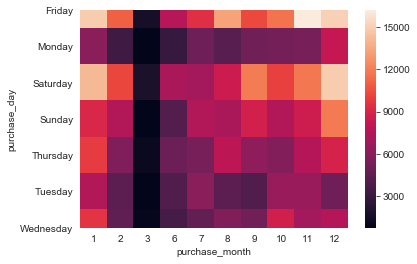

In [15]:
# purchase day x month x revenue 

import seaborn as sns

day_month_monetary = data.groupby(['purchase_day', 'purchase_month']).agg({'restaurant_total': 'sum'}).reset_index()
day_month_monetary = day_month_monetary.pivot('purchase_day', 'purchase_month', 'restaurant_total')
day_month_monetary 
ax = sns.heatmap(day_month_monetary)


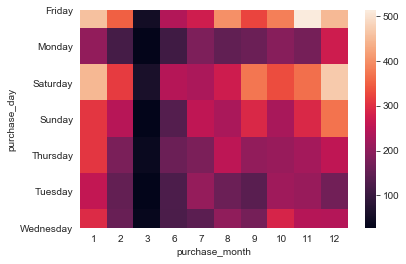

In [16]:
# purchase day x month x order count 

day_month_frequency = data.groupby(['purchase_day', 'purchase_month']).agg({'order_id': 'count'}).reset_index()
day_month_frequency = day_month_frequency.pivot('purchase_day', 'purchase_month', 'order_id')
day_month_frequency
bx = sns.heatmap(day_month_frequency)


The two heatmaps look more or less identical, which indicates that the average order size is quite stable across months. Colors get lighter from June to February, with a dip in March for both revenue total and order count.

In [17]:
# day x time bracket x revenue

day_hour_monetary = data.groupby(['purchase_day', 'time_bracket']).agg({'restaurant_total': 'sum'}).reset_index()
day_hour_monetary = day_hour_monetary.pivot('purchase_day', 'time_bracket', 'restaurant_total')
day_hour_monetary
cx = sns.heatmap(day_hour_monetary)


In [18]:
# purchase day x month x order count 

day_hour_frequency = data.groupby(['purchase_day', 'time_bracket']).agg({'order_id': 'count'}).reset_index()
day_hour_frequency = day_hour_frequency.pivot('purchase_day', 'time_bracket', 'order_id')
day_hour_frequency
dx = sns.heatmap(day_hour_frequency)


Again, two heatmaps are almost identical. 
Popular times are: Friday lunch, Saturday lunch, Sunday lunch, Thursday lunch.
While dinner is more popular than morning for most days, Thursday morning & dinner are almost proportionally good. Perhaps many corporate or networking events are planned for Thursday evening hence ordered in advance in the morning. 

In [19]:
# saving current data set before running LTV 
data.head()
data.info()
data.to_csv("CLTV_3_BeforeLTV.csv", index=False, header=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16131 entries, 0 to 16130
Data columns (total 15 columns):
order_id               16131 non-null int64
source                 16131 non-null object
purchase_date          16131 non-null object
shipping_type          16131 non-null object
payment_method         16131 non-null object
promo_amount           16131 non-null category
restaurant_total       16131 non-null float64
user_id                16131 non-null int64
purchase_year          16131 non-null int64
purchase_month         16131 non-null int64
purchase_day           16131 non-null object
purchase_hour          16131 non-null int64
time_bracket           16131 non-null object
predict                16131 non-null int64
purchase_year_month    16131 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(6), object(6)
memory usage: 1.7+ MB


# Question 2: CLTV Model (BD/BG vs MBD/BG) 

Now that we've looked at cohorts, let's move on to the customer life time value model. 

Customer lifetime value is the present value of the future cash flows associated with the customer. It's calculated by multiplying E(v(t)) = the expected value (or net cashflow) of the customer at time t (if alive) to S(t) = the probability that the customer survives beyond time t to d(t) = discount factor reflecting the present value of money received at time t. For the scope of this analysis and this data set (2018-2019 only), I ignored d(t). 

I first used the BG/NBD model (beta geometric/negative binomial distribution) which improves upon the Pareto/NBD model slightly but relies on the assumption that every customer without a repeat transaction has not defected yet, independent of the elapsed time of inactivity. When I compared the model predictions to actual data, the discrepancy was quite jarring. That's why I also used MBG/NBD model (modified version of BG/NBD), which accounts more realistically for the possibility of customers not making any repurchase than the first model, and got more accurate results. Whether it is truly plausible can only be determined if the data set included more years :) 

## BD/BG Model

In [20]:
# read in data 
data = pd.read_csv('CLTV_3_BeforeLTV.csv')

import lifetimes
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.fitters import *

# select user id, purchase date, and restaurant total 
data=data[['user_id', 'purchase_date', 'restaurant_total', 'predict']]
data['purchase_date'] = pd.to_datetime(data['purchase_date'],yearfirst=True)

data = summary_data_from_transaction_data(data, 'user_id', 'purchase_date', monetary_value_col='restaurant_total')
data.head()

frequency  recency      T  monetary_value
user_id                                           
10000          0.0      0.0  131.0           0.000
10001          2.0    209.0  211.0          14.955
10002          4.0    189.0  250.0          38.100
10003          0.0      0.0   48.0           0.000
10004          0.0      0.0  231.0           0.000

Although the model seemed promising in the actual vs model bar chart, the weakness of the BD/BG model becomes apparent in the next graph where the model tracks the average number of repeat transactions. After 1st purchase in the calibration period, the model diverges severely from the actual data, and overestimates by nearly 50% at 4 purchases. 

Since the BG/BD model's performance is quite disappointing, let's try a MBG/BD model to see if it truly adjusts for the faults in the first model. 

## MBD/BG Model

In [21]:
# reread in og data
# select user id, purchase date, and restaurant total 
data=data[['user_id', 'purchase_date', 'restaurant_total']]
data['purchase_date'] = pd.to_datetime(data['purchase_date'],yearfirst=True)

data = summary_data_from_transaction_data(data, 'user_id', 'purchase_date', monetary_value_col='restaurant_total')
data.head()

# creating a rfm mastrix 
from lifetimes import ModifiedBetaGeoFitter

mbg = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbg.fit(data['frequency'], 
        data['recency'], 
        data['T'],
       verbose=True)

# draw a frequency/recency matrix

from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(mbg)

# predicting which customers will surely be coming back

from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbg)

# evaluating model fit

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbg, max_frequency=7)
ax.set_yscale('log')
sns.despine();

# not terrible at all!! although at 5 transactions, the discrepancy is quite significant.

# reread in original data set now, to partition it into calibration period data and hold out data. 
# This is the time series's equivalent to train/test splittng. 
# I'll choose dates up to 2018/10/15 as the calibration period, as the data set spans from 2018 June to 2019 March.

data = pd.read_csv('CLTV_BeforeLTV.csv')
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(data, 'user_id', 'purchase_date',
                                        calibration_period_end='2018-10-15',
                                        observation_period_end='2019-02-28' )   
print(summary_cal_holdout.head())

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)
sns.despine();

# mbg/bd model's prediction is significantly better than the bg/bd model! while it diverges at 5 transactions, overall much better performance.

KeyError: "None of [Index(['user_id', 'purchase_date', 'restaurant_total'], dtype='object')] are in the [columns]"

The second model performs much better, despite the divergence at 5 purchases in calibration period. Although the last chart posits a clear win for the MBD/BG model, I am a little hesitant since BD/BG outperformed in the frequency comparison chart. With more data points across several years, the model comparsion can become more refined. Regardless, for this analysis, I decided to go with the second model. 

In [45]:
# now that we have a model, let's predict an individual's purchases in the next 2 weeks. 
t = 14
individual = summary_cal_holdout.loc[10007]
mbg.predict(t, individual['frequency_cal'], individual['recency_cal'], individual['T_cal'])

0.14996629034050496

According to the model's prediction, customer ID 10007’s future transaction in the next 14 days is 0.15 (conditional expected number of purchases).

In [46]:
# we can rank customers from our "favorites" (best) to "least favorites" (worst).
# Our Top 5 favorites customers who are most likely to make purchase in the next 2 weeks: 

t = 14
summary_cal_holdout['predicted_purchases'] = mbg.conditional_expected_number_of_purchases_up_to_time(t, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
summary_cal_holdout.sort_values(by='predicted_purchases').tail(5)

frequency_cal  recency_cal  T_cal  frequency_holdout  \
user_id                                                         
11165             11.0         84.0   86.0               10.0   
10887             12.0         78.0   88.0                4.0   
12795              4.0         11.0   13.0                8.0   
14964             14.0         73.0   83.0                5.0   
10161             41.0        112.0  114.0               63.0   

         duration_holdout  predicted_purchases  
user_id                                         
11165                 136             1.346072  
10887                 136             1.347182  
12795                 136             1.372215  
14964                 136             1.616722  
10161                 136             4.036101

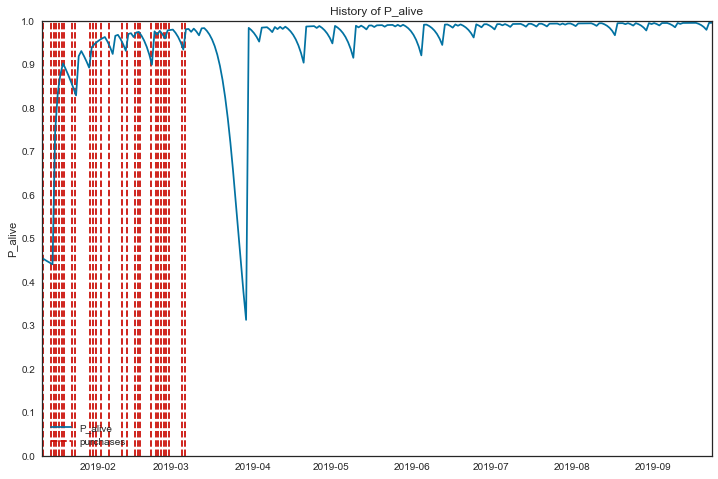

In [47]:
# we can also track our best customer's lifetime history! 

from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 10161
days_since_birth = 90
sp_trans = data.loc[data['user_id'] == id]
plot_history_alive(mbg, days_since_birth, sp_trans, 'purchase_date')


According to the model, customer 10161 is definitely still alive and active, although we have no data from April onwards to verify the predicted hiatus in April.

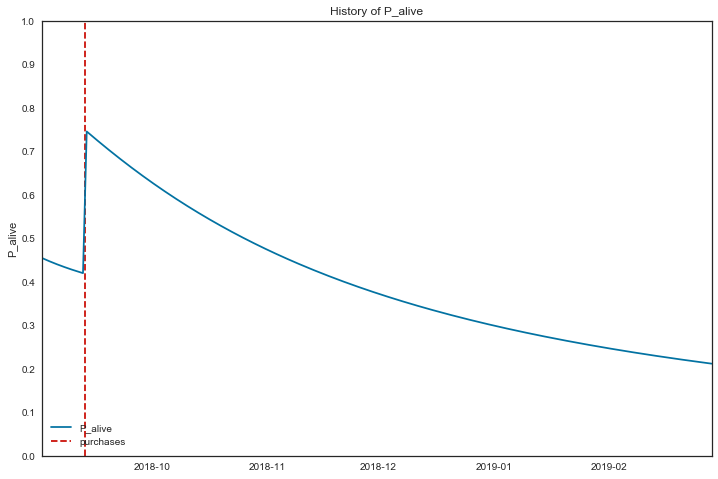

In [48]:
# let's track another customer's history for comparison. 

from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 10007
days_since_birth = 180
sp_trans = data.loc[data['user_id'] == id]
plot_history_alive(mbg, days_since_birth, sp_trans, 'purchase_date')


According to the model, customer 10007 is definitely still alive, although the probaiblity of him/her being alive has been steadily diminshing since his/her last purchase in mid-September.

Now let's tackle the "life time value" question by using the monetary value column we had selected from the data set. It's interesting to note that the Gamma-gamma model I'll be using assumes that there is no relationship between the monetary value and the purchase frequency, which was partially validated in our heatmap analysis in Section 4 3), where the average order size seemed stable across months. 

In [49]:
# only select customers with at least one repeat purchase (at least 2 purchases total)

data = pd.read_csv('CLTV_BeforeLTV.csv')
data=data[['user_id', 'purchase_date', 'restaurant_total']]
data['purchase_date'] = pd.to_datetime(data['purchase_date'],yearfirst=True)
data = summary_data_from_transaction_data(data, 'user_id', 'purchase_date', monetary_value_col='restaurant_total')

returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

         frequency  recency      T  monetary_value
user_id                                           
10001          2.0    209.0  211.0          14.955
10002          4.0    189.0  250.0          38.100
10005          1.0     13.0  263.0          42.910
10007          1.0     12.0  187.0          82.010
10011          2.0     20.0  240.0          22.265
2308


In [50]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2308 subjects, p: 13.34, q: 6.22, v: 12.22>

In [51]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(15))

print("Expected conditional average profit: %s, Average profit: %s" % (
ggf.conditional_expected_average_profit(
data['frequency'],
data['monetary_value']
).mean(),
data[data['frequency']>0]['monetary_value'].mean()
))

user_id
10000    31.227147
10001    17.618445
10002    37.487385
10003    31.227147
10004    31.227147
10005    39.623424
10007    67.723959
10009    31.227147
10010    31.227147
10011    23.731935
10012    34.953761
10013    30.072116
10014    31.227147
10015    31.227147
10016    38.322606
dtype: float64
Expected conditional average profit: 31.327923391141777, Average profit: 31.980913643273237


The expected lifetime value (which is the average transaction value) is 31.98 for repeat customers, only slightly above the entire data set's median of 29. This reveals that the probability of repeat purchases is currently and predicted to be very low in the near future. This also highlights the fact that the average order size doesn't vary significantly over time, for both repeat and non-repeat customers. I guess there's a limit to how much pizza you can eat at once. But all jokes aside, frequency is something we can work on through campaign and strategy optimizations.

# Question 3 & 4: Insights & Analysis

I've written most of the insights & analyses in the previous sections, but to briefly summarize, 

1) Dataset can be segmented into 3 or 6 cohorts, with one cohort consisting strictly of call orders. 

2) 31.98 dollars is the value each customer brings to the company over their lifetime.

3) Average order size for pizza is stable across months and both repeat & non-repeat customers. 

4) Source efficiency (ROI) is web > google > androidapp > iosapp. Call orders are much more efficient than call-center orders.

5) Delivery > Pick up in revenue per user. 

6) Lunch (11am-5pm) > dinner (5-11pm) > morning (5am-11am) > late night (11pm-5am) in order popularity.

7) Winter weekend lunches are the most popular, and Thursday is an anomaly when mornings are almost as popular as dinners. 

Ideas to A/B test & Data Caveats:

1. Hourly/Weekend promotions: Digitally targeting customers with discounts via advertisements or emails during lunch or dinner times should be tested. There also seems to be no seasonal/holiday/weekday/weekend promotions in place, but weekends may definitely be a profitable option where order count outweighs the discounted price. 

2. Call order promotions: it's interesting to note taht call orders outperform call-center digitized orders. Perhaps local pizzeria regulars prefer the good old mom and pop style of calling the restaurant directly. What is the company currently doing to promote call orders even further? Enabling real-time widgets to display messages like "fresh out of the oven" whenever the new dough is made could be a method to induce urgency and user engagement. This will make the restaurant brand and story seem even more authentic, immediate, and human. 

3. IOS vs Android app: Interseting to see that Android app has better ROI than ios. If I could get more customer data, I'd love to conduct a deep dive demographical analysis of the ios vs android app users, to see if we can optimize the design and promotion strategies accordingly. 

4. I need more data. More historcial data to conduct a full-on time series modeling, more rows needed to group users into 6 clusters for a more refined segmentation, advertising/media data to understand how the users got to the company website and optimize marketing strategy per channel, and geo/delivery time data to analyze during and post-purchase user experience and which neighborhoods to expand the company's territory in. I would also like to explore using regression models and other types of clustering models since the data is limited to 2018-2019, as part of a follow-up analysis.
